# Extracting the Neon lines flux values from phot tables and calculating the ratios [NeV]/[NeII], [NeV]/[NeIII] and [NeIII]/[NeII]

In [1]:
from astropy.table import Table, Column, table, vstack
from pathlib import Path

import numpy as np
import astropy.units as u

from matplotlib import pyplot as plt

In [2]:
path_raw='../Datos/Raw/'
path_phot_ned = '../Datos/Work/Phot_Tables_NED/' #In this path wi will save the photometry tables for each object
path_phot_cds = '../Datos/Work/Phot_Tables_CDS/'
path_SED = '../Datos/Work/SEDs/'
path_CIGALE_phot = '../Datos/Work/CIGALE_InputPhot/'
path_CIGALE_out = '../Datos/Work/CIGALE_Output/'
path_FINAL = '../Datos/Final/'

In [3]:
date_sample = 'Sep_02_2022'
NeV_NeII_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')
NeV_NeIII_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')
NeIII_NeII_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')

In [4]:
#Rows to be deleted or removed in each table
to_rem1 = [] 
to_rem2 = []
to_rem3 = []

for i in range(len(NeV_NeII_Sy)): 
    if (NeV_NeII_Sy['NED_Ne_IR_info'][i] != 'NeII|NeIII|NeV' and NeV_NeII_Sy['NED_Ne_IR_info'][i]!= 'NeII|NeV'):
        to_rem1.append(i)
        
for i in range(len(NeV_NeIII_Sy)): 
    if (NeV_NeIII_Sy['NED_Ne_IR_info'][i] != 'NeII|NeIII|NeV' and NeV_NeIII_Sy['NED_Ne_IR_info'][i]!= 'NeIII|NeV'):
        to_rem2.append(i)

for i in range(len(NeIII_NeII_Sy)): 
    if (NeV_NeII_Sy['NED_Ne_IR_info'][i] != 'NeII|NeIII|NeV' and NeV_NeII_Sy['NED_Ne_IR_info'][i]!= 'NeII|NeIII'):
        to_rem3.append(i)
    
NeV_NeII_Sy.remove_rows(to_rem1)
NeV_NeIII_Sy.remove_rows(to_rem2)
NeIII_NeII_Sy.remove_rows(to_rem3)
#NeII_NeV_Sy.show_in_notebook()
print('Total objects with [NeV] and [NeII] info:',len(NeV_NeII_Sy))
print('Total objects with [NeV] and [NeIII] info:',len(NeV_NeIII_Sy))
print('Total objects with [NeIII] and [NeII] info:',len(NeIII_NeII_Sy))

Total objects with [NeV] and [NeII] info: 183
Total objects with [NeV] and [NeIII] info: 181
Total objects with [NeIII] and [NeII] info: 227


In [5]:
def Neon_info(NED_table, Freq):
    
    '''
    This function create a new table from the Phot NED table
    but with the flux of [NeII] and [NeV]
    '''
    
    NED_table.remove_rows(np.where(NED_table['Flux_Density'].mask)[0])
    NED_table.remove_rows(np.where(NED_table['NED_Units'] == 'Jy')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] line (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] 14.4 (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] 14.37 (IRS)')[0])
    
    Ne_idx = [np.where(NED_table['Frequency'] == freq)[0] for freq in Freq]
    #print(Ne_idx)
    #print(len(Ne_idx))
    i = []
    Ne_table = Table()
    for idx in range(len(Freq)):
        Ne_table = vstack([Ne_table,NED_table[Ne_idx[idx]]])
    
    for ind in range(len(Ne_table)):
        i.append(ind)
    
    Ne_table['idx'] = i
    Ne_inf = Ne_table['idx','Observed_Passband','Flux_Density','NED_Uncertainty','NED_Units','Refcode']
    obs_passb = np.unique(Ne_inf['Observed_Passband'])
    #print(obs_passb)
    return Ne_inf

In [6]:
def Ne_ratios(Ne_info,Nel1,Nel2,Nel1a,Nel2a,not_same_bib):
    
    '''
    This function is for compute the ratio between two Neon
    emission lines (line1/line2) that have the same bibcode
    '''
    
    bibcod, count = np.unique(Ne_info['Refcode'], return_counts=True)
    print('No. of [Ne] data',len(Ne_info))
    flag = 0 #Flag to detect when there is not info of the two Ne lines for the same bibcode
    print('Neon line 1:',Nel1,'& Neon line 2:',Nel2)
    print('Others filter names for Neon line1:',Nel1a,'& Neon line 2:',Nel2a)
    Ne_ratio = []
    Ne_filter = []
    refcode = []
    
    print(Ne_info)
    for idx,bib in enumerate(bibcod):
        i = np.where(Ne_info['Refcode'] == bib)[0]
        #The ratio [Ne]line1/[Ne]line2 is calculated for only the bibcodes that have both flux data
        if len(i)>=2:
            flag += 1
            #print(len(i))
            Neline1_i = 'nan'
            Neline2_i = 'nan'
            for j,ind in enumerate(i):
                if Nel1 in Ne_info['Observed_Passband'][ind] or Nel1a in Ne_info['Observed_Passband'][ind]:
                    #print('yes:',Nel1)
                    Neline1_i = ind
                elif Nel2 in Ne_info['Observed_Passband'][ind] or Nel2a in Ne_info['Observed_Passband'][ind]:
                    #print('yes:',Nel2)
                    Neline2_i = ind
            if Neline1_i != 'nan' and Neline2_i != 'nan':
                Neline1 = Ne_info['Flux_Density'][Neline1_i]
                Neline2 = Ne_info['Flux_Density'][Neline2_i]
                Neline1_Neline2_ratio = Neline1/Neline2
                Ne_ratio.append(Neline1_Neline2_ratio)
                Ne_filter.append(Ne_info['Observed_Passband'][Neline1_i])
                Ne_filter.append(Ne_info['Observed_Passband'][Neline2_i])
                refcode.append(bib)
                #print('For bibcode',',',bib,Nel1,'index is:',Neline1_i,'and',Nel2,'index is:',Neline2_i)
                print('For bibcode', bib,Nel1,'/',Nel2,'ratio is:',Neline1_Neline2_ratio)
    if flag<1:
        flag = 0
        not_same_bib += 1
        #for r in range(len(NeV_NeII_inf)): refcode.append(NeV_NeII_inf['Refcode'][r])
         
    return Ne_ratio, Ne_filter, refcode, not_same_bib

In the galaxies where there are more than one data of [NeII] or [NeV], we remove the rows if per bibcode there is data for only one the them. The idea is to have both [NeII] and [NeV] data per bibcode:

## [NeV]/[NeII]

In [7]:
Nefilter = []
Refcode = []
NeV_NeII = Table(names=('Main_id','[NeV]/[NeII]','[NeV]/[NeII]_err'),
                dtype=('O','f8','f8'))

not_same_bib = 0

for id in range(len(NeV_NeII_Sy)):
    NED_phot = Table()
    obj = NeV_NeII_Sy['Main_Id'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    NeV_NeII_Freq = [20900000000000.0,21000000000000.0,23400000000000.0]
    NeV_NeII_inf = Neon_info(NED_phot, NeV_NeII_Freq)
    
    NeV_NeII_ratios,Ne_filter,refcode,not_same_bib = Ne_ratios(NeV_NeII_inf,'[Ne V]','[Ne II]','nan',\
                                                             'nan',not_same_bib)
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
        
    avg_Ne_ratios = np.average(NeV_NeII_ratios)
    std_Ne_ratios = np.std(NeV_NeII_ratios)
    NeV_NeII_row = [obj,avg_Ne_ratios,std_Ne_ratios]
    NeV_NeII.add_row(vals=NeV_NeII_row)

    print(NeV_NeII_ratios)
    print(refcode)
    print('\n') 

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 2350000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  1  [Ne V] 14.3 microns 3300000000.0 ...     Jy-Hz 2006ApJ...647..161O
  2   [Ne II] 12.8 (IRS) 1400000000.0 ...     Jy-Hz 2009ApJ...697..182T
  3 [Ne II] 12.81 micron  800000000.0 ...     Jy-Hz 2006ApJ...647..161O
For bibcode 2006ApJ...647..161O [Ne V] / [Ne II] ratio is: 4.125
[4.125]
['2006ApJ...647..161O']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 7
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode   

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband  Flux_Density ... NED_Units       Refcode      
                             Jy      ...                              
--- ------------------- ------------ ... --------- -------------------
  0  [Ne V] 14.32 (IRS)  959000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1 [Ne II] 12.81 (IRS) 6270000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2011ApJ...740...94D [Ne V] / [Ne II] ratio is: 0.15295055821371611
[0.15295055821371611]
['2011ApJ...740...94D']


11
Galaxy:  NGC  4941
Phot table lenght: 198
No. of [Ne] data 9
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0   [Ne V]

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Phot table lenght: 19
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0  [Ne V] 14.3 Spitzer 2600000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  1 [Ne II] 12.8 Spitzer 1500000000.0 ...     Jy-Hz 2010ApJ...725.2270P
For bibcode 2010ApJ...725.2270P [Ne V] / [Ne II] ratio is: 1.7333333333333334
[1.7333333333333334]
['2010ApJ...725.2270P']


19
Galaxy:  NGC  3281
Phot table lenght: 150
No. of [Ne] data 4
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband  Flux_Density ... NED_Units       Refcode      
                             Jy      ...                              
--- ------------------- ------------ ... --------- -------------------
  0  [Ne V] 14.32 (IRS) 1160000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  1 [Ne II] 12.81 (IRS) 1400000000.0 ...     Jy-Hz 2010ApJ...716.1151W
For bibcode 2010ApJ...716.1151W [Ne V] / [Ne II] ratio is: 0.8285714285714286
[0.8285714285714286]
['2010ApJ...716.1151W']


27
Galaxy:  NGC  1142
Phot table lenght: 257
No. of [Ne] data 5
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- ------------------- ------------- ... --------- -------------------
  0        [Ne V]

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 4
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx Observed_Passband  Flux_Density ... NED_Units       Refcode      
                            Jy      ...                              
--- ------------------ ------------ ... --------- -------------------
  0       [Ne V] 14.32 2210000000.0 ...     Jy-Hz 2011ApJS..195...17W
  1      [Ne II] 12.81 3230000000.0 ...     Jy-Hz 2011ApJS..195...17W
  2  [Ne II] (Spitzer) 2000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  3 [Ne II] 12.8 (IRS) 7800000000.0 ...     Jy-Hz 2009ApJ...697..182T
For bibcode 2011ApJS..195...17W [Ne V] / [Ne II] ratio is: 0.6842105263157895
[0.6842105263157895]
['2011ApJS..195...17W']


34
Galaxy:  Mrk 1513
Phot table lenght: 216
No. of [Ne] data 7
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                           

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 124
No. of [Ne] data 5
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- ------------------- ------------- ... --------- -------------------
  0  [Ne V] 14.32 (IRS)  1520000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  1        [Ne V] 14.32  1910000000.0 ...     Jy-Hz 2011ApJS..195...17W
  2   [Ne II] (Spitzer) 11000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  3       [Ne II] 12.81 12800000000.0 ...     Jy-Hz 2011ApJS..195...17W
  4 [Ne II] 12.81 (IRS) 10400000000.0 ...     Jy-Hz 2010ApJ...716.1151W
For bibcode 2010ApJ...716.1151W [Ne V] / [Ne II] ratio is: 0.14615384615384616
For bibcode 2011ApJS..195...17W [Ne V] / [Ne II] ratio is: 0.14921875
[0.14615384615384616, 0.14921875]
['2010ApJ...716.1151W', '2011ApJS..195...17W']


45
Galaxy:  ESO 383-35
Phot table lenght: 271
No. of [Ne] data 11


No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- ------------------- ------------- ... --------- -------------------
  0  [Ne V] 14.32 (IRS)  6990000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1 [Ne II] 12.81 (IRS) 10800000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2011ApJ...740...94D [Ne V] / [Ne II] ratio is: 0.6472222222222223
[0.6472222222222223]
['2011ApJ...740...94D']


54
Galaxy:  ESO 113-45
Phot table lenght: 199
No. of [Ne] data 6
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0    [Ne 

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0 [Ne V] 14.32 Spitzer  4000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  1    [Ne II] (Spitzer) 16000000000.0 ...     Jy-Hz 2007ApJ...671..124D
For bibcode 2007ApJ...671..124D [Ne V] / [Ne II] ratio is: 0.25
[0.25]
['2007ApJ...671..124D']


65
Galaxy:  IRAS 13342+3932
Phot table lenght: 97
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband  Flux_Density ... NED_Units       Refcode      
                             Jy      ...                              
--- ------------------- ------------ ... --------- -------------------
  0  [Ne V] 14.32 (IRS) 340000000

Phot table lenght: 147
No. of [Ne] data 5
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0   [Ne V] 14.32 (IRS)  3870000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1 [Ne V] 14.32 Spitzer  9000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  2  [Ne II] 12.81 (IRS) 21400000000.0 ...     Jy-Hz 2011ApJ...740...94D
  3 [Ne II] 12.8 Spitzer 22200000000.0 ...     Jy-Hz 2010ApJ...725..605S
  4    [Ne II] (Spitzer) 12000000000.0 ...     Jy-Hz 2007ApJ...671..124D
For bibcode 2007ApJ...671..124D [Ne V] / [Ne II] ratio is: 0.75
For bibcode 2011ApJ...740...94D [Ne V] / [Ne II] ratio is: 0.1808411214953271
[0.75, 0.1808411214953271]
['2007ApJ...671..124D', '2011ApJ...740...94D']


76
Galaxy:  NGC  3079
Phot table lenght: 331
No. of [N

For bibcode 2010ApJ...725.2270P [Ne V] / [Ne II] ratio is: 0.4636363636363636
For bibcode 2011ApJ...740...94D [Ne V] / [Ne II] ratio is: 0.4576271186440678
For bibcode 2011ApJS..195...17W [Ne V] / [Ne II] ratio is: 0.3385714285714286
[0.5191666666666667, 0.3385714285714286, 0.6341666666666667, 0.4636363636363636, 0.4576271186440678, 0.3385714285714286]
['2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


82
Galaxy:  ESO   5-4
Phot table lenght: 127
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- ------------------- ------------- ... --------- -------------------
  0  [Ne V] 14.32 (IRS)   500000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  1 [Ne II] 12.81 (IRS) 16600000000.0 ...     Jy-H

No. of [Ne] data 5
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 1150000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1 [Ne V] 14.32 Spitzer  930000000.0 ...     Jy-Hz 2008ApJ...674L...9D
  2         [Ne V] (IRS)  906000000.0 ...     Jy-Hz 2006ApJ...649...79S
  3        [Ne II] (IRS)  613000000.0 ...     Jy-Hz 2006ApJ...649...79S
  4  [Ne II] 12.81 (IRS)  584000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2006ApJ...649...79S [Ne V] / [Ne II] ratio is: 1.4779771615008157
For bibcode 2011ApJ...740...94D [Ne V] / [Ne II] ratio is: 1.9691780821917808
[1.4779771615008157, 1.9691780821917808]
['2006ApJ...649...79S', '2011ApJ...740...94D']


93
Galaxy:  Mrk  876
Phot table lenght: 206
No. of [Ne] d

Phot table lenght: 128
No. of [Ne] data 6
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 10700000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  1         [Ne V] 14.32  8000000000.0 ...     Jy-Hz 2011ApJS..195...17W
  2 [Ne V] 14.32 Spitzer  8000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  3    [Ne II] (Spitzer)  9000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  4  [Ne II] 12.81 (IRS)  9580000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  5        [Ne II] 12.81  9000000000.0 ...     Jy-Hz 2011ApJS..195...17W
For bibcode 2007ApJ...671..124D [Ne V] / [Ne II] ratio is: 0.8888888888888888
For bibcode 2010ApJ...709.1257T [Ne V] / [Ne II] ratio is: 1.116910229645094
For bibcode 2011ApJS..195...17W [Ne V] / [Ne

Phot table lenght: 72
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband  Flux_Density ... NED_Units       Refcode      
                             Jy      ...                              
--- ------------------- ------------ ... --------- -------------------
  0  [Ne V] 14.32 (IRS) 1660000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1 [Ne II] 12.81 (IRS)  867000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2011ApJ...740...94D [Ne V] / [Ne II] ratio is: 1.9146482122260668
[1.9146482122260668]
['2011ApJ...740...94D']


108
Galaxy:  NGC   931
Phot table lenght: 237
No. of [Ne] data 7
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -----------

Phot table lenght: 353
No. of [Ne] data 8
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- ------------------- ------------- ... --------- -------------------
  0  [Ne V] 14.32 (IRS) 10600000000.0 ...     Jy-Hz 2011ApJS..193...18W
  1  [Ne V] 14.32 (IRS) 11200000000.0 ...     Jy-Hz 2011ApJ...740...94D
  2   [Ne V] line (IRS) 12900000000.0 ...     Jy-Hz 2007ApJ...656..148A
  3        [Ne V] 14.32 10600000000.0 ...     Jy-Hz 2007ApJ...664...71D
  4 [Ne V] 14.3 Spitzer 10100000000.0 ...     Jy-Hz 2011ApJ...730...28P
  5 [Ne II] 12.81 (IRS) 41200000000.0 ...     Jy-Hz 2011ApJS..193...18W
  6 [Ne II] 12.81 (IRS) 44500000000.0 ...     Jy-Hz 2011ApJ...740...94D
  7  [Ne II] line (IRS) 53500000000.0 ...     Jy-Hz 2007ApJ...656..148A
For bibcode 2007ApJ...656..148A [Ne V] / [Ne II] ratio is: 0.241

No. of [Ne] data 9
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0 [Ne V] 14.32 Spitzer 11000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  1   [Ne V] 14.32 (IRS)  6760000000.0 ...     Jy-Hz 2011ApJ...740...94D
  2         [Ne V] 14.32  7880000000.0 ...     Jy-Hz 2011ApJS..195...17W
  3  [Ne V] 14.3 Spitzer  7300000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  4 [Ne II] 12.8 Spitzer  7200000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  5  [Ne II] 12.81 (IRS)  7400000000.0 ...     Jy-Hz 2011ApJ...740...94D
  6        [Ne II] 12.81  8070000000.0 ...     Jy-Hz 2011ApJS..195...17W
  7   [Ne II] 12.8 (IRS)   990000000.0 ...     Jy-Hz 2009ApJ...697..182T
  8    [Ne II] (Spitzer)  8000000000.0 ...     Jy-Hz 2007ApJ...671..124D
For

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- ------------------- ------------- ... --------- -------------------
  0  [Ne V] 14.32 (IRS)  6810000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  1 [Ne II] 12.81 (IRS) 16000000000.0 ...     Jy-Hz 2010ApJ...709.1257T
For bibcode 2010ApJ...709.1257T [Ne V] / [Ne II] ratio is: 0.425625
[0.425625]
['2010ApJ...709.1257T']


135
Galaxy:  Ton  1565
Phot table lenght: 120
No. of [Ne] data 3
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx Observed_Passband  Flux_Density ... NED_Units       Refcode      
                            Jy      ...                              
--- ------------------ ------------ ... --------- -------------------
  0       [Ne V] (IRS)  269000000.0 .

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 8
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density  ... NED_Units       Refcode      
                              Jy       ...                              
--- ------------------- -------------- ... --------- -------------------
  0  [Ne V] 14.32 (IRS)   9020000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1        [Ne V] 14.32   5100000000.0 ...     Jy-Hz 2007ApJ...664...71D
  2        [Ne V] (IRS)   5100000000.0 ...     Jy-Hz 2006ApJ...640..204A
  3 [Ne V] 14.3 Spitzer   2070000000.0 ...     Jy-Hz 2011ApJ...730...28P
  4 [Ne II] 12.81 (IRS) 187000000000.0 ...     Jy-Hz 2011ApJ...740...94D
  5       [Ne II] (IRS) 193000000000.0 ...     Jy-Hz 2006ApJ...640..204A
  6    [Ne II] (TIMMI2)  50000000000.0 ...     Jy-Hz 2004A&A...414..123S
  7       [Ne II] (ISO) 170000000000.0 ...     Jy-Hz 2004A&A...414..123S
For bibcode 2006ApJ...640..204A [Ne V] / [Ne II] ratio is: 0.026424870466321

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 10
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband    Flux_Density  ... NED_Units       Refcode      
                               Jy       ...                              
--- -------------------- -------------- ... --------- -------------------
  0   [Ne V] 14.32 (IRS)  63300000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1 [Ne V] 14.32 Spitzer 109000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  2         [Ne V] 14.32 109000000000.0 ...     Jy-Hz 2011ApJS..195...17W
  3         [Ne V] 14.32  64500000000.0 ...     Jy-Hz 2007ApJ...664...71D
  4    [Ne V] 14.3 (IRS)  64600000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  5 [Ne II] 12.8 Spitzer  87500000000.0 ...     Jy-Hz 2010ApJ...725..605S
  6  [Ne II] 12.81 (IRS)  98000000000.0 ...     Jy-Hz 2011ApJ...740...94D
  7    [Ne II] (Spitzer)  86000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  8        [Ne II] 12.81  86000000000.0 ...     Jy-Hz 2011ApJS..

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx Observed_Passband  Flux_Density ... NED_Units       Refcode      
                            Jy      ...                              
--- ------------------ ------------ ... --------- -------------------
  0  [Ne V] 14.3 (IRS) 1610000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  1 [Ne II] 12.8 (IRS) 1760000000.0 ...     Jy-Hz 2009ApJ...690.1105K
For bibcode 2009ApJ...690.1105K [Ne V] / [Ne II] ratio is: 0.9147727272727273
[0.9147727272727273]
['2009ApJ...690.1105K']


159
Galaxy:  NGC  5929
Phot table lenght: 187
No. of [Ne] data 7
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0   [Ne V] 14.32

No. of [Ne] data 3
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx Observed_Passband Flux_Density NED_Uncertainty NED_Units       Refcode      
                           Jy                                                   
--- ----------------- ------------ --------------- --------- -------------------
  0 [Ne V] 14.3 (IRS)  480000000.0                     Jy-Hz 2009ApJ...690.1105K
  1      [Ne V] (IRS)  487000000.0                     Jy-Hz 2006ApJ...649...79S
  2     [Ne II] (IRS)  356000000.0                     Jy-Hz 2006ApJ...649...79S
For bibcode 2006ApJ...649...79S [Ne V] / [Ne II] ratio is: 1.3679775280898876
[1.3679775280898876]
['2006ApJ...649...79S']


171
Galaxy:  Z 121-75
Phot table lenght: 107
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband  Flux_Density ... NED_Units       Refcode      
                             Jy

Phot table lenght: 239
No. of [Ne] data 7
Neon line 1: [Ne V] & Neon line 2: [Ne II]
Others filter names for Neon line1: nan & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- ------------------- ------------- ... --------- -------------------
  0        [Ne V] 14.32 21000000000.0 ...     Jy-Hz 2011ApJS..195...17W
  1  [Ne V] 14.32 (IRS) 21000000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  2  [Ne V] 14.32 (IRS) 22100000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  3       [Ne II] 12.81 23300000000.0 ...     Jy-Hz 2011ApJS..195...17W
  4 [Ne II] 12.81 (IRS) 24300000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  5 [Ne II] 12.81 (IRS) 23300000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  6  [Ne II] 12.8 (IRS) 33000000000.0 ...     Jy-Hz 2009ApJ...697..182T
For bibcode 2010ApJ...709.1257T [Ne V] / [Ne II] ratio is: 0.9012875536480687
For bibcode 2010ApJ...716.1151W [Ne V] / [Ne II] ratio is:

In [8]:
Ne_filters, countspb = np.unique(Nefilter, return_counts=True)
for pb in range(len(Ne_filters)): print(Ne_filters[pb])

[Ne II] (IRS)
[Ne II] (Spitzer)
[Ne II] 12.8 (IRS)
[Ne II] 12.8 Spitzer
[Ne II] 12.81
[Ne II] 12.81 (IRS)
[Ne II] 12.81 micron
[Ne II] line (IRS)
[Ne V] (IRS)
[Ne V] 14.3 (IRS)
[Ne V] 14.3 Spitzer
[Ne V] 14.3 microns
[Ne V] 14.32
[Ne V] 14.32 (IRS)
[Ne V] 14.32 Spitzer
[Ne V] line (IRS)


In [9]:
refcodes, countsrc = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes)): print(refcodes[rc])

In [10]:
print('Number of galaxies with diferent bibcode for [NeV] and [NeII] fluxes:',not_same_bib)

Number of galaxies with diferent bibcode for [NeV] and [NeII] fluxes: 5


In [11]:
NeV_NeII[46]

Main_id,[NeV]/[NeII],[NeV]/[NeII]_err
object,float64,float64
NGC 973,0.2577833125778331,0.0


## [NeV]/[NeIII]

In [12]:
Nefilter = []
Refcode = []
NeV_NeIII = Table(names=('Main_id','[NeV]/[NeIII]','[NeV]/[NeIII]_err'),
                 dtype=('O','f8','f8'))

not_same_bib = 0

for id in range(len(NeV_NeIII_Sy)):
    NED_phot = Table()
    obj = NeV_NeIII_Sy['Main_Id'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    #Put first the frequencies of the Ne line 1 and then the Ne line 2
    NeV_NeIII_Freq = [20900000000000.0,21000000000000.0,19200000000000.0,19300000000000.0]
    NeV_NeIII_inf = Neon_info(NED_phot, NeV_NeIII_Freq)
    
    NeV_NeIII_ratios,Ne_filter,refcode,not_same_bib = Ne_ratios(NeV_NeIII_inf,'[Ne V]','[Ne III]','nan',\
                                                             '[NeIII]',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
        
    avg_Ne_ratios = np.average(NeV_NeIII_ratios)
    std_Ne_ratios = np.std(NeV_NeIII_ratios)
    NeV_NeIII_row = [obj,avg_Ne_ratios,std_Ne_ratios]
    NeV_NeIII.add_row(vals=NeV_NeIII_row)
    
    print(NeV_NeIII_ratios)
    print(refcode)
    print('\n')

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 2350000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  1  [Ne V] 14.3 microns 3300000000.0 ...     Jy-Hz 2006ApJ...647..161O
  2 [Ne III] 15.56 (IRS) 3400000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  3 [Ne III] 15.55 micrn 8200000000.0 ...     Jy-Hz 2006ApJ...647..161O
For bibcode 2006ApJ...647..161O [Ne V] / [Ne III] ratio is: 0.4024390243902439
For bibcode 2010ApJ...709.1257T [Ne V] / [Ne III] ratio is: 0.6911764705882353
[0.4024390243902439, 0.6911764705882353]
['2006ApJ...647..161O', '2010ApJ...709.1257T']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 7
Neon line 1: [Ne

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx Observed_Passband Flux_Density NED_Uncertainty NED_Units       Refcode      
                           Jy                                                   
--- ----------------- ------------ --------------- --------- -------------------
  0      [Ne V] 14.32 5780000000.0                     Jy-Hz 2011ApJS..195...17W
  1    [Ne III] 15.56 8130000000.0                     Jy-Hz 2011ApJS..195...17W
For bibcode 2011ApJS..195...17W [Ne V] / [Ne III] ratio is: 0.7109471094710947
[0.7109471094710947]
['2011ApJS..195...17W']


9
Galaxy:  Z 218-7
Phot table lenght: 87
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- -------

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 3
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 2470000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1  [Ne III] 15 Spitzer 9100000000.0 ...     Jy-Hz 2010ApJ...725..605S
  2 [Ne III] 15.56 (IRS) 8040000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2011ApJ...740...94D [Ne V] / [Ne III] ratio is: 0.3072139303482587
[0.3072139303482587]
['2011ApJ...740...94D']


18
Galaxy:  NGC   863
Phot table lenght: 198
No. of [Ne] data 4
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
-

No. of [Ne] data 6
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0         [Ne V] 14.32  6080000000.0 ...     Jy-Hz 2011ApJS..195...17W
  1   [Ne V] 14.32 (IRS)  6080000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  2 [Ne V] 14.32 Spitzer 10000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  3       [Ne III] 15.56  9350000000.0 ...     Jy-Hz 2011ApJS..195...17W
  4   [Ne III] (Spitzer) 15000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  5 [Ne III] 15.56 (IRS)  9350000000.0 ...     Jy-Hz 2010ApJ...709.1257T
For bibcode 2007ApJ...671..124D [Ne V] / [Ne III] ratio is: 0.6666666666666666
For bibcode 2010ApJ...709.1257T [Ne V] / [Ne III] ratio is: 0.6502673796791444
For bibcode 2011ApJS..195...17W [Ne V] / [Ne III] ratio is:

No. of [Ne] data 6
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0    [Ne V] 14.3 (IRS) 3800000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  1 [Ne V] 14.32 Spitzer 4060000000.0 ...     Jy-Hz 2008ApJ...674L...9D
  2   [Ne V] 14.32 (IRS) 4520000000.0 ...     Jy-Hz 2011ApJ...740...94D
  3         [Ne V] 14.32 4200000000.0 ...     Jy-Hz 2007ApJ...664...71D
  4  [Ne III] 15.5 (IRS) 6190000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  5 [Ne III] 15.56 (IRS) 5570000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2009ApJ...690.1105K [Ne V] / [Ne III] ratio is: 0.6138933764135702
For bibcode 2011ApJ...740...94D [Ne V] / [Ne III] ratio is: 0.8114901256732495
[0.6138933764135702, 0.8114901256732495]
['2009ApJ...690.1105K', '20

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 1420000000.0 ...     Jy-Hz 2012ApJ...747...95G
  1 [Ne III] 15.55 (IRS) 8620000000.0 ...     Jy-Hz 2012ApJ...747...95G
For bibcode 2012ApJ...747...95G [Ne V] / [Ne III] ratio is: 0.16473317865429235
[0.16473317865429235]
['2012ApJ...747...95G']


45
Galaxy:  NGC   513
Phot table lenght: 124
No. of [Ne] data 5
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS)  500000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  1 [Ne III] 15.56 (IRS) 1760000000.0 ...     Jy-Hz 2010ApJ...716.1151W
For bibcode 2010ApJ...716.1151W [Ne V] / [Ne III] ratio is: 0.2840909090909091
[0.2840909090909091]
['2010ApJ...716.1151W']


54
Galaxy:  MCG+10-17-021
Phot table lenght: 94
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- ---------------

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 1790000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1 [Ne III] 15.56 (IRS) 2260000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2011ApJ...740...94D [Ne V] / [Ne III] ratio is: 0.7920353982300885
[0.7920353982300885]
['2011ApJ...740...94D']


63
Galaxy:  ESO 417-6
Phot table lenght: 78
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 3
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 1000000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1 [Ne III] 15.56 (IRS) 4330000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  2 [Ne III] 15.56 (IRS) 3520000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2011ApJ...740...94D [Ne V] / [Ne III] ratio is: 0.2840909090909091
[0.2840909090909091]
['2011ApJ...740...94D']


72
Galaxy:  IC  486
Phot table lenght: 130
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
---

No. of [Ne] data 15
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0    [Ne V] 14.3 (IRS)  6230000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  1 [Ne V] 14.32 Spitzer  6290000000.0 ...     Jy-Hz 2008ApJ...674L...9D
  2  [Ne V] 14.3 Spitzer  5100000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  3   [Ne V] 14.32 (IRS)  7610000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  4   [Ne V] 14.32 (IRS)  5400000000.0 ...     Jy-Hz 2011ApJ...740...94D
  5         [Ne V] 14.32  4740000000.0 ...     Jy-Hz 2011ApJS..195...17W
  6   [Ne V] 14.32 (IRS)  4740000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  7  [Ne V] 14.3 microns  8600000000.0 ...     Jy-Hz 2007ApJ...655L..73G
  8 [NeIII] 15.6 microns 15600000000.0 ...     Jy-Hz 2007ApJ...655L..7

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0  [Ne V] 14.3 Spitzer 25000000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  1 [NeIII] 15.6 Spitzer 49000000000.0 ...     Jy-Hz 2010ApJ...725.2270P
For bibcode 2010ApJ...725.2270P [Ne V] / [Ne III] ratio is: 0.5102040816326531
[0.5102040816326531]
['2010ApJ...725.2270P']


90
Galaxy:  NAME Centaurus A
Phot table lenght: 532
No. of [Ne] data 9
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density  ... NED_Units       Refcode      
                               Jy       ...                              
--- -------------------- -------------- ... --------- ---

Phot table lenght: 169
No. of [Ne] data 6
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0   [Ne V] 14.32 (IRS)  1320000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  1         [Ne V] 14.32  1320000000.0 ...     Jy-Hz 2011ApJS..195...17W
  2 [Ne III] 15.56 (IRS)  7230000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  3 [NeIII] 15.6 Spitzer  6900000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  4       [Ne III] 15.56  7230000000.0 ...     Jy-Hz 2011ApJS..195...17W
  5   [Ne III] (Spitzer) 19000000000.0 ...     Jy-Hz 2007ApJ...671..124D
For bibcode 2010ApJ...709.1257T [Ne V] / [Ne III] ratio is: 0.1825726141078838
For bibcode 2011ApJS..195...17W [Ne V] / [Ne III] ratio is: 0.1825726141078838
[0.1825726141078838, 0.1825726141078

No. of [Ne] data 4
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0  [Ne V] 14.3 microns 42400000000.0 ...     Jy-Hz 2007ApJ...655L..73G
  1         [Ne V] 14.32 42400000000.0 ...     Jy-Hz 2011ApJS..195...17W
  2 [NeIII] 15.6 microns 95000000000.0 ...     Jy-Hz 2007ApJ...655L..73G
  3       [Ne III] 15.56 95000000000.0 ...     Jy-Hz 2011ApJS..195...17W
For bibcode 2007ApJ...655L..73G [Ne V] / [Ne III] ratio is: 0.4463157894736842
For bibcode 2011ApJS..195...17W [Ne V] / [Ne III] ratio is: 0.4463157894736842
[0.4463157894736842, 0.4463157894736842]
['2007ApJ...655L..73G', '2011ApJS..195...17W']


108
Galaxy:  2MASX J10181928+3722419
Phot table lenght: 72
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [N

No. of [Ne] data 6
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 2880000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  1 [Ne V] 14.32 Spitzer 8000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  2         [Ne V] 14.32 1860000000.0 ...     Jy-Hz 2011ApJS..195...17W
  3       [Ne III] 15.56 4580000000.0 ...     Jy-Hz 2011ApJS..195...17W
  4   [Ne III] (Spitzer) 4000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  5 [Ne III] 15.56 (IRS) 5510000000.0 ...     Jy-Hz 2010ApJ...716.1151W
For bibcode 2007ApJ...671..124D [Ne V] / [Ne III] ratio is: 2.0
For bibcode 2010ApJ...716.1151W [Ne V] / [Ne III] ratio is: 0.5226860254083484
For bibcode 2011ApJS..195...17W [Ne V] / [Ne III] ratio is: 0.40611353711790393
[2.

No. of [Ne] data 4
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0  [Ne V] 14.3 Spitzer  1600000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  1    [Ne V] 14.3 (IRS)  2260000000.0 ...     Jy-Hz 2011ApJ...740...99D
  2 [NeIII] 15.6 Spitzer  7600000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  3 [Ne III] 15.55 (IRS) 13000000000.0 ...     Jy-Hz 2011ApJ...740...99D
For bibcode 2010ApJ...725.2270P [Ne V] / [Ne III] ratio is: 0.21052631578947367
For bibcode 2011ApJ...740...99D [Ne V] / [Ne III] ratio is: 0.17384615384615384
[0.21052631578947367, 0.17384615384615384]
['2010ApJ...725.2270P', '2011ApJ...740...99D']


126
Galaxy:  MCG-03-34-064
Phot table lenght: 236
No. of [Ne] data 7
Neon line 1: [Ne V] & Neon line 2: [Ne III

No. of [Ne] data 4
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 1950000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  1    [Ne V] 14.3 (IRS) 3650000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  2  [Ne III] 15.5 (IRS) 3820000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  3 [Ne III] 15.56 (IRS) 6230000000.0 ...     Jy-Hz 2010ApJ...709.1257T
For bibcode 2009ApJ...690.1105K [Ne V] / [Ne III] ratio is: 0.9554973821989529
For bibcode 2010ApJ...709.1257T [Ne V] / [Ne III] ratio is: 0.3130016051364366
[0.9554973821989529, 0.3130016051364366]
['2009ApJ...690.1105K', '2010ApJ...709.1257T']


132
Galaxy:  NGC  7319
Phot table lenght: 99
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter 

No. of [Ne] data 7
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0    [Ne V] line (IRS) 18400000000.0 ...     Jy-Hz 2007ApJ...656..148A
  1   [Ne V] 14.32 (IRS) 15300000000.0 ...     Jy-Hz 2011ApJ...740...94D
  2         [Ne V] 14.32 19000000000.0 ...     Jy-Hz 2011ApJS..195...17W
  3  [Ne V] 14.3 Spitzer 15100000000.0 ...     Jy-Hz 2011ApJ...730...28P
  4 [Ne III] 15.56 (IRS) 18600000000.0 ...     Jy-Hz 2011ApJ...740...94D
  5  [Ne III] line (IRS) 18600000000.0 ...     Jy-Hz 2007ApJ...656..148A
  6       [Ne III] 15.56 18000000000.0 ...     Jy-Hz 2011ApJS..195...17W
For bibcode 2007ApJ...656..148A [Ne V] / [Ne III] ratio is: 0.989247311827957
For bibcode 2011ApJ...740...94D [Ne V] / [Ne III] ratio is: 0.8225

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 2010000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1 [Ne III] 15.56 (IRS) 2560000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2011ApJ...740...94D [Ne V] / [Ne III] ratio is: 0.78515625
[0.78515625]
['2011ApJ...740...94D']


150
Galaxy:  Mrk  705
Phot table lenght: 181
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.3

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0 [Ne V] 14.32 Spitzer 17000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  1   [Ne III] (Spitzer) 24000000000.0 ...     Jy-Hz 2007ApJ...671..124D
For bibcode 2007ApJ...671..124D [Ne V] / [Ne III] ratio is: 0.7083333333333334
[0.7083333333333334]
['2007ApJ...671..124D']


162
Galaxy:  NGC  3660
Phot table lenght: 100
No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx Observed_Passband Flux_Density NED_Uncertainty NED_Units       Refcode      
                           Jy                                                   
--- ----------------- ------------ --------------

No. of [Ne] data 2
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0   [Ne V] 14.32 (IRS) 1640000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1 [Ne III] 15.56 (IRS) 4730000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2011ApJ...740...94D [Ne V] / [Ne III] ratio is: 0.346723044397463
[0.346723044397463]
['2011ApJ...740...94D']


171
Galaxy:  Mrk  841
Phot table lenght: 206
No. of [Ne] data 7
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------


No. of [Ne] data 11
Neon line 1: [Ne V] & Neon line 2: [Ne III]
Others filter names for Neon line1: nan & Neon line 2: [NeIII]
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0  [Ne V] 14.3 Spitzer 12000000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  1   [Ne V] 14.32 (IRS) 12600000000.0 ...     Jy-Hz 2011ApJ...740...94D
  2   [Ne V] 14.32 (IRS) 12500000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  3    [Ne V] 14.3 (IRS) 10600000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  4         [Ne V] 14.32 18400000000.0 ...     Jy-Hz 2011ApJS..195...17W
  5  [Ne V] 14.3 microns 18400000000.0 ...     Jy-Hz 2007ApJ...655L..73G
  6 [NeIII] 15.6 microns 49600000000.0 ...     Jy-Hz 2007ApJ...655L..73G
  7 [NeIII] 15.6 Spitzer 29000000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  8 [Ne III] 15.56 (IRS) 28800000000.0 ...     Jy-Hz 2011ApJ...740...9

In [13]:
Ne_filters, countspb = np.unique(Nefilter, return_counts=True)
for pb in range(len(Ne_filters)): print(Ne_filters[pb])

[Ne III] (IRS)
[Ne III] (Spitzer)
[Ne III] 15.5 (IRS)
[Ne III] 15.55 (IRS)
[Ne III] 15.55 micrn
[Ne III] 15.56
[Ne III] 15.56 (IRS)
[Ne III] 15.6 (IRS)
[Ne III] line (IRS)
[Ne V] (IRS)
[Ne V] 14.3 (IRS)
[Ne V] 14.3 Spitzer
[Ne V] 14.3 microns
[Ne V] 14.32
[Ne V] 14.32 (IRS)
[Ne V] 14.32 Spitzer
[Ne V] line (IRS)
[NeIII] 15.6 Spitzer
[NeIII] 15.6 microns


In [14]:
refcodes, countsrc = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes)): print(refcodes[rc])

In [15]:
print('Number of galaxies with diferent bibcode for [NeV] and [NeIII] fluxes:',not_same_bib)

Number of galaxies with diferent bibcode for [NeV] and [NeIII] fluxes: 4


## [NeIII]/[NeII]

In [16]:
Nefilter = []
Refcode = []
NeIII_NeII = Table(names=('Main_id','[NeIII]/[NeII]','[NeIII]/[NeII]_err'),
                   dtype=('O','f8','f8'))

not_same_bib = 0

for id in range(len(NeIII_NeII_Sy)):
    NED_phot = Table()
    obj = NeIII_NeII_Sy['Main_Id'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    #Put first the frequencies of the Ne line 1 and then the Ne line 2
    NeIII_NeII_Freq = [19200000000000.0,19300000000000.0,23400000000000.0]
    NeIII_NeII_inf = Neon_info(NED_phot, NeIII_NeII_Freq)
    
    NeIII_NeII_ratios,Ne_filter,refcode,not_same_bib = Ne_ratios(NeIII_NeII_inf,'[Ne III]','[Ne II]','[NeIII]',\
                                                             'nan',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
    
    avg_Ne_ratios = np.average(NeIII_NeII_ratios)
    std_Ne_ratios = np.std(NeIII_NeII_ratios)
    NeIII_NeII_row = [obj,avg_Ne_ratios,std_Ne_ratios]
    NeIII_NeII.add_row(vals=NeIII_NeII_row)

    print(NeIII_NeII_ratios)
    print(refcode)
    print('\n')

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [Ne III] 15.56 (IRS) 3400000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  1 [Ne III] 15.55 micrn 8200000000.0 ...     Jy-Hz 2006ApJ...647..161O
  2   [Ne II] 12.8 (IRS) 1400000000.0 ...     Jy-Hz 2009ApJ...697..182T
  3 [Ne II] 12.81 micron  800000000.0 ...     Jy-Hz 2006ApJ...647..161O
For bibcode 2006ApJ...647..161O [Ne III] / [Ne II] ratio is: 10.25
[10.25]
['2006ApJ...647..161O']


1
Galaxy:  2MASS J13000535+1632148
Phot table lenght: 98
No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband  Flux_Density ... 

No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0 [NeIII] 15.6 Spitzer 13000000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  1 [Ne II] 12.8 Spitzer  9400000000.0 ...     Jy-Hz 2010ApJ...725.2270P
For bibcode 2010ApJ...725.2270P [Ne III] / [Ne II] ratio is: 1.3829787234042554
[1.3829787234042554]
['2010ApJ...725.2270P']


11
Galaxy:  NGC  4477
Phot table lenght: 178
No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------

No. of [Ne] data 5
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0  [Ne III] 15 Spitzer 9100000000.0 ...     Jy-Hz 2010ApJ...725..605S
  1 [Ne III] 15.56 (IRS) 8040000000.0 ...     Jy-Hz 2011ApJ...740...94D
  2 [Ne II] 12.8 Spitzer 5000000000.0 ...     Jy-Hz 2010ApJ...725..605S
  3    [Ne II] (Spitzer) 6000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  4  [Ne II] 12.81 (IRS) 6200000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2010ApJ...725..605S [Ne III] / [Ne II] ratio is: 1.82
For bibcode 2011ApJ...740...94D [Ne III] / [Ne II] ratio is: 1.2967741935483872
[1.82, 1.2967741935483872]
['2010ApJ...725..605S', '2011ApJ...740...94D']


22
Galaxy:  NGC   863
Phot table lenght: 198
No. of [Ne] data 2
Neon line 1

No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [Ne III] 15.56 (IRS) 1380000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  1  [Ne II] 12.81 (IRS) 1400000000.0 ...     Jy-Hz 2010ApJ...716.1151W
For bibcode 2010ApJ...716.1151W [Ne III] / [Ne II] ratio is: 0.9857142857142858
[0.9857142857142858]
['2010ApJ...716.1151W']


33
Galaxy:  NGC  1142
Phot table lenght: 257
No. of [Ne] data 5
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- ---------------

No. of [Ne] data 5
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0 [NeIII] 15.6 microns 25500000000.0 ...     Jy-Hz 2007ApJ...655L..73G
  1  [Ne III] 15.5 (IRS) 25300000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  2 [NeIII] 15.6 Spitzer 24000000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  3   [Ne II] 12.8 (IRS)  7740000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  4 [Ne II] 12.8 Spitzer  8100000000.0 ...     Jy-Hz 2010ApJ...725.2270P
For bibcode 2009ApJ...690.1105K [Ne III] / [Ne II] ratio is: 3.268733850129199
For bibcode 2010ApJ...725.2270P [Ne III] / [Ne II] ratio is: 2.962962962962963
[3.268733850129199, 2.962962962962963]
['2009ApJ...690.1105K', '2010ApJ...725.2270P']


44
Galaxy:  NGC  4151
Phot table lenght: 55

No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [Ne III] 15.55 (IRS) 8620000000.0 ...     Jy-Hz 2012ApJ...747...95G
  1  [Ne II] 12.81 (IRS) 4150000000.0 ...     Jy-Hz 2012ApJ...747...95G
For bibcode 2012ApJ...747...95G [Ne III] / [Ne II] ratio is: 2.07710843373494
[2.07710843373494]
['2012ApJ...747...95G']


55
Galaxy:  M  81
Phot table lenght: 294
No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0

No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [Ne III] 15.56 (IRS) 4950000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1  [Ne II] 12.81 (IRS) 3320000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2011ApJ...740...94D [Ne III] / [Ne II] ratio is: 1.4909638554216869
[1.4909638554216869]
['2011ApJ...740...94D']


66
Galaxy:  NGC  7591
Phot table lenght: 213
No. of [Ne] data 4
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- ---------------

No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0 [Ne III] 15.56 (IRS) 19600000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  1  [Ne II] 12.81 (IRS) 18400000000.0 ...     Jy-Hz 2010ApJ...716.1151W
For bibcode 2010ApJ...716.1151W [Ne III] / [Ne II] ratio is: 1.065217391304348
[1.065217391304348]
['2010ApJ...716.1151W']


77
Galaxy:  ESO 417-6
Phot table lenght: 78
No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- ----------------

No. of [Ne] data 4
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0  [Ne III] 15.5 (IRS) 3280000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  1 [Ne III] 15.56 (IRS) 2940000000.0 ...     Jy-Hz 2011ApJ...740...94D
  2   [Ne II] 12.8 (IRS) 2590000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  3  [Ne II] 12.81 (IRS) 2190000000.0 ...     Jy-Hz 2011ApJ...740...94D
For bibcode 2009ApJ...690.1105K [Ne III] / [Ne II] ratio is: 1.2664092664092663
For bibcode 2011ApJ...740...94D [Ne III] / [Ne II] ratio is: 1.3424657534246576
[1.2664092664092663, 1.3424657534246576]
['2009ApJ...690.1105K', '2011ApJ...740...94D']


88
Galaxy:  Mrk 1095
Phot table lenght: 202
No. of [Ne] data 4
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filt

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [Ne III] 15.56 (IRS) 6790000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  1  [Ne II] 12.81 (IRS) 6860000000.0 ...     Jy-Hz 2010ApJ...716.1151W
For bibcode 2010ApJ...716.1151W [Ne III] / [Ne II] ratio is: 0.9897959183673469
[0.9897959183673469]
['2010ApJ...716.1151W']


92
Galaxy:  Mrk  618
Phot table lenght: 127
No. of [Ne] data 4
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- ----------------

No. of [Ne] data 15
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0 [NeIII] 15.6 microns 15600000000.0 ...     Jy-Hz 2007ApJ...655L..73G
  1 [Ne III] 15.56 (IRS) 15300000000.0 ...     Jy-Hz 2011ApJ...740...94D
  2 [Ne III] 15.56 (IRS) 14500000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  3 [Ne III] 15.56 (IRS) 17300000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  4       [Ne III] 15.56 14500000000.0 ...     Jy-Hz 2011ApJS..195...17W
  5  [Ne III] 15.5 (IRS) 16800000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  6 [NeIII] 15.6 Spitzer 16000000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  7   [Ne II] 12.8 (IRS) 12000000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  8        [Ne II] (ISO) 13000000000.0 ...     Jy-Hz 2004A&A...414..1

No. of [Ne] data 3
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0 [NeIII] 15.6 Spitzer 49000000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  1    [Ne II] (GeminiS) 22900000000.0 ...     Jy-Hz 2010ApJ...711..328D
  2 [Ne II] 12.8 Spitzer 40000000000.0 ...     Jy-Hz 2010ApJ...725.2270P
For bibcode 2010ApJ...725.2270P [Ne III] / [Ne II] ratio is: 1.225
[1.225]
['2010ApJ...725.2270P']


112
Galaxy:  NAME Centaurus A
Phot table lenght: 532
No. of [Ne] data 10
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density  ... NED_Units       Refcode      
                               Jy       ...                              
--- -

No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [Ne III] 15.55 (IRS) 1000000000.0 ...     Jy-Hz 2012ApJ...747...95G
  1  [Ne II] 12.81 (IRS) 3110000000.0 ...     Jy-Hz 2012ApJ...747...95G
For bibcode 2012ApJ...747...95G [Ne III] / [Ne II] ratio is: 0.3215434083601286
[0.3215434083601286]
['2012ApJ...747...95G']


122
Galaxy:  NGC  1320
Phot table lenght: 128
No. of [Ne] data 6
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- --------------

No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [NeIII] 15.6 Spitzer 1100000000.0 ...     Jy-Hz 2010ApJ...725.2270P
  1 [Ne II] 12.8 Spitzer 2300000000.0 ...     Jy-Hz 2010ApJ...725.2270P
For bibcode 2010ApJ...725.2270P [Ne III] / [Ne II] ratio is: 0.4782608695652174
[0.4782608695652174]
['2010ApJ...725.2270P']


133
Galaxy:  M  58
Phot table lenght: 433
No. of [Ne] data 3
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- ------------------

Phot table lenght: 147
No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density  ... NED_Units       Refcode      
                               Jy       ...                              
--- -------------------- -------------- ... --------- -------------------
  0 [Ne III] 15.56 (IRS)  13400000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  1  [Ne II] 12.81 (IRS) 103000000000.0 ...     Jy-Hz 2010ApJ...709.1257T
For bibcode 2010ApJ...709.1257T [Ne III] / [Ne II] ratio is: 0.13009708737864079
[0.13009708737864079]
['2010ApJ...709.1257T']


144
Galaxy:  Mrk  273
Phot table lenght: 353
No. of [Ne] data 6
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- --------

Phot table lenght: 390
No. of [Ne] data 7
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0  [Ne III] line (IRS) 18700000000.0 ...     Jy-Hz 2007ApJ...656..148A
  1 [Ne III] 15.55 (IRS) 23900000000.0 ...     Jy-Hz 2004ApJS..154..178A
  2 [Ne III] 15.56 (IRS) 14600000000.0 ...     Jy-Hz 2011ApJ...740...94D
  3   [Ne II] 12.8 (IRS) 64000000000.0 ...     Jy-Hz 2009ApJ...697..182T
  4  [Ne II] 12.81 (IRS) 38000000000.0 ...     Jy-Hz 2011ApJ...740...94D
  5  [Ne II] 12.81 (IRS) 55200000000.0 ...     Jy-Hz 2004ApJS..154..178A
  6   [Ne II] line (IRS) 43600000000.0 ...     Jy-Hz 2007ApJ...656..148A
For bibcode 2004ApJS..154..178A [Ne III] / [Ne II] ratio is: 0.4329710144927536
For bibcode 2007ApJ...656..148A [Ne III]

No. of [Ne] data 4
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0  [Ne III] 15.5 (IRS) 3820000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  1 [Ne III] 15.56 (IRS) 6230000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  2   [Ne II] 12.8 (IRS) 2900000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  3  [Ne II] 12.81 (IRS) 2310000000.0 ...     Jy-Hz 2010ApJ...709.1257T
For bibcode 2009ApJ...690.1105K [Ne III] / [Ne II] ratio is: 1.3172413793103448
For bibcode 2010ApJ...709.1257T [Ne III] / [Ne II] ratio is: 2.696969696969697
[1.3172413793103448, 2.696969696969697]
['2009ApJ...690.1105K', '2010ApJ...709.1257T']


164
Galaxy:  2MASX J18334627+4727027
Phot table lenght: 145
No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne I

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 7
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0   [Ne III] (Spitzer)  7000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  1 [Ne III] 15.56 (IRS)  5070000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  2       [Ne III] 15.56  7000000000.0 ...     Jy-Hz 2011ApJS..195...17W
  3   [Ne II] 12.8 (IRS) 19000000000.0 ...     Jy-Hz 2009ApJ...697..182T
  4    [Ne II] (Spitzer) 11000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  5        [Ne II] 12.81 11000000000.0 ...     Jy-Hz 2011ApJS..195...17W
  6  [Ne II] 12.81 (IRS)  9320000000.0 ...     Jy-Hz 2010ApJ...716.1151W
For bibcode 2007ApJ...671..124D [Ne III] / [Ne II] ratio is: 0.6363636363636364
For bibcode 2010ApJ...716.1151W [Ne III] / [Ne II] ratio is: 0.

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 3
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [Ne III] 15.56 (IRS) 1560000000.0 ...     Jy-Hz 2011ApJ...740...94D
  1  [Ne III] 15.5 (IRS) 2600000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  2   [Ne II] 12.8 (IRS)  982000000.0 ...     Jy-Hz 2009ApJ...690.1105K
For bibcode 2009ApJ...690.1105K [Ne III] / [Ne II] ratio is: 2.6476578411405294
[2.6476578411405294]
['2009ApJ...690.1105K']


178
Galaxy:  LEDA   17155
Phot table lenght: 266
No. of [Ne] data 6
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                       

No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [Ne III] 15.55 micrn 1900000000.0 ...     Jy-Hz 2006ApJ...647..161O
  1 [Ne II] 12.81 micron 2110000000.0 ...     Jy-Hz 2006ApJ...647..161O
For bibcode 2006ApJ...647..161O [Ne III] / [Ne II] ratio is: 0.9004739336492891
[0.9004739336492891]
['2006ApJ...647..161O']


187
Galaxy:  LEDA  165630
Phot table lenght: 88
No. of [Ne] data 2
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- ---------------

No. of [Ne] data 4
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband    Flux_Density ... NED_Units       Refcode      
                               Jy      ...                              
--- -------------------- ------------- ... --------- -------------------
  0 [Ne III] 15.56 (IRS) 47400000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  1  [Ne III] 15.5 (IRS) 45400000000.0 ...     Jy-Hz 2009ApJ...690.1105K
  2  [Ne II] 12.81 (IRS) 60200000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  3   [Ne II] 12.8 (IRS) 56900000000.0 ...     Jy-Hz 2009ApJ...690.1105K
For bibcode 2009ApJ...690.1105K [Ne III] / [Ne II] ratio is: 0.7978910369068541
For bibcode 2010ApJ...716.1151W [Ne III] / [Ne II] ratio is: 0.7873754152823921
[0.7978910369068541, 0.7873754152823921]
['2009ApJ...690.1105K', '2010ApJ...716.1151W']


199
Galaxy:  2MASS J10514425+3539307
Phot table lenght: 97
No. of [Ne] data 3
Neon line 1: [Ne III] & Neon line 

No. of [Ne] data 6
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [Ne III] 15.56 (IRS) 7370000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  1   [Ne III] (Spitzer) 9000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  2 [Ne III] 15.56 (IRS) 8270000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  3  [Ne II] 12.81 (IRS) 3270000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  4    [Ne II] (Spitzer) 5000000000.0 ...     Jy-Hz 2007ApJ...671..124D
  5  [Ne II] 12.81 (IRS) 3810000000.0 ...     Jy-Hz 2010ApJ...709.1257T
For bibcode 2007ApJ...671..124D [Ne III] / [Ne II] ratio is: 1.8
For bibcode 2010ApJ...709.1257T [Ne III] / [Ne II] ratio is: 1.9343832020997376
For bibcode 2010ApJ...716.1151W [Ne III] / [Ne II] ratio is: 2.529051987767584
[

No. of [Ne] data 7
Neon line 1: [Ne III] & Neon line 2: [Ne II]
Others filter names for Neon line1: [NeIII] & Neon line 2: nan
idx  Observed_Passband   Flux_Density ... NED_Units       Refcode      
                              Jy      ...                              
--- -------------------- ------------ ... --------- -------------------
  0 [Ne III] 15.56 (IRS) 7500000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  1 [Ne III] 15.56 (IRS) 6650000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  2       [Ne III] 15.56 6650000000.0 ...     Jy-Hz 2011ApJS..195...17W
  3  [Ne II] 12.81 (IRS) 5600000000.0 ...     Jy-Hz 2010ApJ...709.1257T
  4  [Ne II] 12.81 (IRS) 5880000000.0 ...     Jy-Hz 2010ApJ...716.1151W
  5   [Ne II] 12.8 (IRS) 6900000000.0 ...     Jy-Hz 2009ApJ...697..182T
  6        [Ne II] 12.81 5600000000.0 ...     Jy-Hz 2011ApJS..195...17W
For bibcode 2010ApJ...709.1257T [Ne III] / [Ne II] ratio is: 1.1875
For bibcode 2010ApJ...716.1151W [Ne III] / [Ne II] ratio is: 1.2755102040816326
For b

In [17]:
Ne_filters, countspb = np.unique(Nefilter, return_counts=True)
for pb in range(len(Ne_filters)): print(Ne_filters[pb])

[Ne III] (IRS)
[Ne III] (Spitzer)
[Ne III] 15 Spitzer
[Ne III] 15.5 (IRS)
[Ne III] 15.55 (IRS)
[Ne III] 15.55 micrn
[Ne III] 15.56
[Ne III] 15.56 (IRS)
[Ne III] 15.6 (IRS)
[Ne III] line (IRS)
[Ne II] (IRS)
[Ne II] (Spitzer)
[Ne II] 12.8 (IRS)
[Ne II] 12.8 Spitzer
[Ne II] 12.81
[Ne II] 12.81 (IRS)
[Ne II] 12.81 micron
[Ne II] line (IRS)
[NeIII] 15.6 Spitzer


In [18]:
refcodes, countsrc = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes)): print(refcodes[rc])

In [19]:
print('Number of galaxies with diferent bibcode for [NeIII] and [NeII] fluxes:',not_same_bib)

Number of galaxies with diferent bibcode for [NeIII] and [NeII] fluxes: 2


## Histograms of the Neon lines ratios:

In [20]:
bins_NeV_NeII = np.linspace(min(NeV_NeII['[NeV]/[NeII]']),max(NeV_NeII['[NeV]/[NeII]']),50)
bins_NeV_NeIII = np.linspace(min(NeV_NeIII['[NeV]/[NeIII]']),max(NeV_NeIII['[NeV]/[NeIII]']),50)
bins_NeIII_NeII = np.linspace(min(NeIII_NeII['[NeIII]/[NeII]']),max(NeIII_NeII['[NeIII]/[NeII]']),50)

### [NeV]/[NeII]

Text(0, 0.5, 'Number of galaxies')

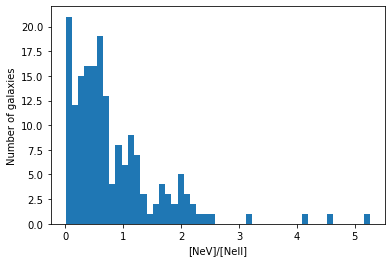

In [21]:
plt.hist(NeV_NeII['[NeV]/[NeII]'], bins=bins_NeV_NeII)
plt.xlabel('[NeV]/[NeII]')
plt.ylabel('Number of galaxies')

### [NeV]/[NeIII]

Text(0, 0.5, 'Number of galaxies')

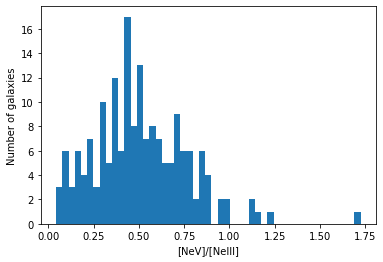

In [22]:
plt.hist(NeV_NeIII['[NeV]/[NeIII]'], bins=bins_NeV_NeIII)
plt.xlabel('[NeV]/[NeIII]')
plt.ylabel('Number of galaxies')

### [NeIII]/[NeII]

Text(0, 0.5, 'Number of galaxies')

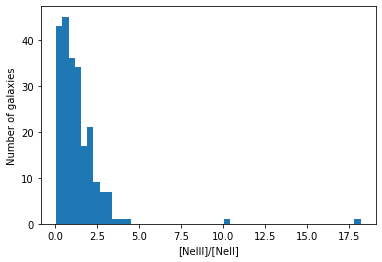

In [23]:
plt.hist(NeIII_NeII['[NeIII]/[NeII]'], bins=bins_NeIII_NeII)
plt.xlabel('[NeIII]/[NeII]')
plt.ylabel('Number of galaxies')

## Notebook Info

In [24]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.4.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-47-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.1

numpy     : 1.21.5
matplotlib: 3.5.1
astropy   : 5.1

Watermark: 2.3.1

